<img src="https://www.thestatesman.com/wp-content/uploads/2019/01/Green-chillies.jpg" width="200" align="center">

<h3><center>Alexandra Almeida</center></h3> 
<h1><center>Project "Green Chilly Prices in India"</center></h1>
<img src="https://upskill.pt/wp-content/uploads/2020/03/cropped-APDC_UPSKILLS_Logo-300x83.png" width="200" align="center">

#### The present project was carried out under the Machine Learning module as part of the UpsKill program @ ISCTE - Lisbon University Institute.

- I have select a public dataset which contains a time list of chilli peppers prices in India over 2048 days. The goal is to forecast prices for next 30 days.

- The initial dataset had almost 900k rows. Every time I restarted the kernel and ran all, the data upload took a long time, so I had to reduce the data file.

- Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) were applied to predict the prices. I have also attempted to use the Profet library but it the instalation process did not end.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# import excel file and convert into pandas
df = pd.read_csv('Chillies Prices in India.csv', delimiter=';')
df.head()

,datesk,Item Name,Date,price
0,20110101,Chillies Green,01/01/2011,NaN
1,20110101,Chillies Bajji,01/01/2011,NaN
2,20110101,Chillies Cleaned,01/01/2011,NaN
3,20110101,Chillies small (C.B.P),01/01/2011,NaN
4,20110101,Chillies Bajji yagani,01/01/2011,NaN


In [3]:
# check dataframe'shape
df.shape

(13065, 4)

In [4]:
# keep green chillies data only 
df = df[(df['Item Name'] == 'Chillies Green')]
df.shape

(2613, 4)

In [5]:
#drop missing values
df.dropna(inplace=True)

In [6]:
#convert the 'Date' column into a datetime format so that it can interpreted as a date
df['Date'] = pd.to_datetime(df['datesk'], format="%Y%m%d")
df.head()

,datesk,Item Name,Date,price
339,20110309,Chillies Green,2011-03-09,30.0
340,20110310,Chillies Green,2011-03-10,30.0
360,20110314,Chillies Green,2011-03-14,30.0
370,20110316,Chillies Green,2011-03-16,30.0
378,20110317,Chillies Green,2011-03-17,30.0


In [7]:
# remove column 'datesk' and 'Item Name'
df.drop(columns = ['datesk','Item Name'], inplace=True)

In [8]:
# remove rows where price is 0
df = df[~(df['price']== 0)]
df.reset_index(drop=True, inplace=True)
df.shape

(2048, 2)

In [9]:
# get the general descriptive statistics from data
df.describe()

,price
count,2048.000000
mean,35.721191
std,21.060151
min,16.000000
25%,25.000000
50%,30.000000
75%,40.000000
max,598.000000


After cleaning all columns and rows not needed, we can plot the data and visualize the prices evolution. We can see 2 data points where prices were much higher than usual.

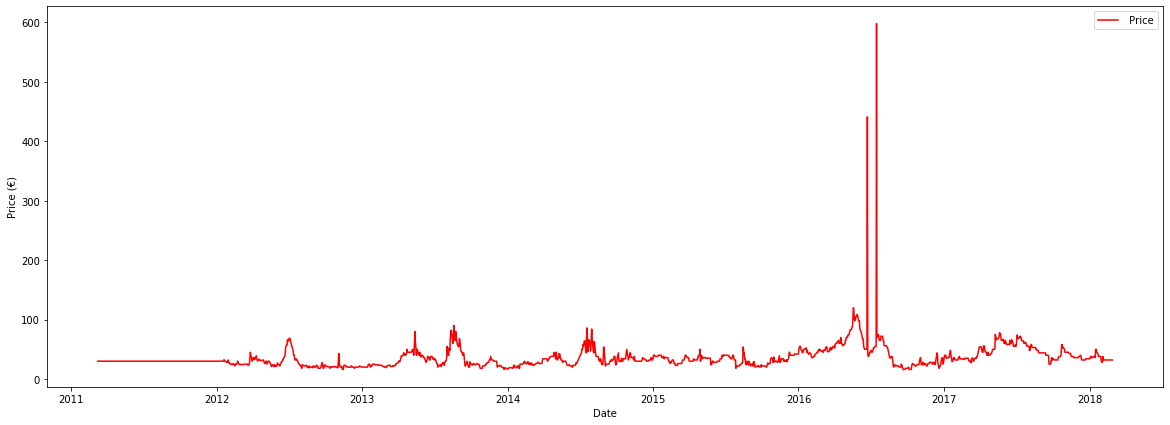

In [10]:
#sort data from older to newer prices
df.sort_values(by=['Date'], ascending = True, inplace = True)

# creating a pot in order to visualize the price evolution.
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],100))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

In [11]:
# sort the dataframe by descending price in order to find the 2 outlier prices
df.sort_values(by=['price'], ascending=False)

,Date,price
1592,2016-07-15,598.0
1574,2016-06-22,441.0
1544,2016-05-18,120.0
1545,2016-05-19,115.0
1551,2016-05-26,108.0
...,...,...
1649,2016-10-07,16.0
1648,2016-10-06,16.0
1638,2016-09-22,16.0
1639,2016-09-24,16.0


In [12]:
#remove prices values 598.0 and 441.0
outliers = df.index[[1574,1592]]
df.drop(outliers, inplace=True)


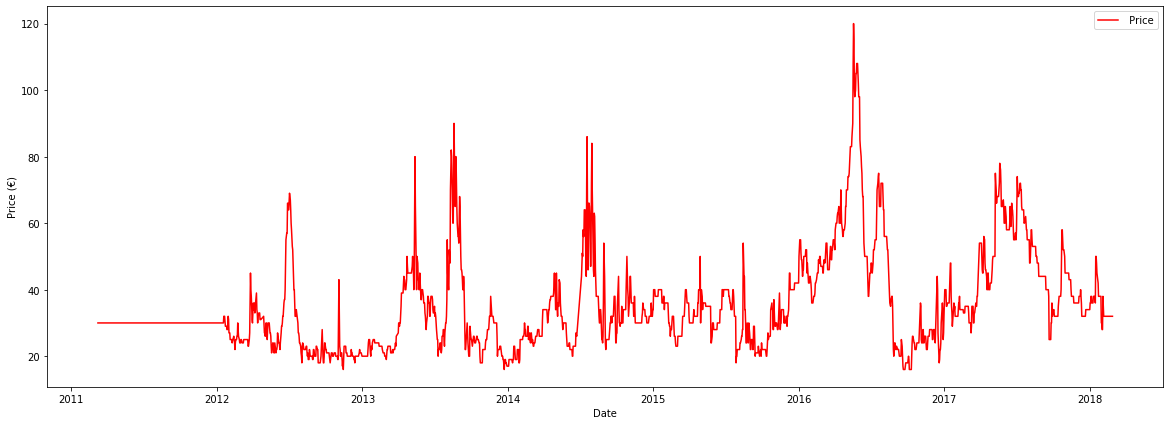

In [13]:
#Create a new plot without ouliers
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
# plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## LSTM  (Long Short-Term Memory)

In [14]:
# split the ordered dataset into train and test datasets
# 80% of the number of records for training
num_records = round(len(df)*0.8)
train = df.iloc[:num_records, 1:2].values
test = df.iloc[num_records:, 1:2].values

Scaling features using normalization. 

In [15]:
# Normalize the data to avoid gradient vanishing using MinMax method 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)

create a feature array, window size = 30

In [16]:
X_train = []

#Price on next day
y_train = []

window = 30

for i in range(window, num_records):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
    
X_train = np.stack(X_train)
y_train = np.stack(y_train)

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Training the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *

# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

Optimizer Adaptive Moment Estimation (Adam) nearly always works faster and more reliably reaching a global minimum when minimising the cost function in training neural nets. We are trying to minimizes the mean squared error value as we fit the model.

Larger epoch values with smaller batch size reduced the MSE error while fitting the model, but the MSE global value was higher. The images below show one of other attempts trying to get the best fit:

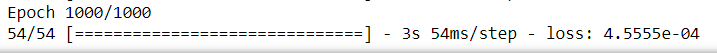

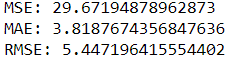

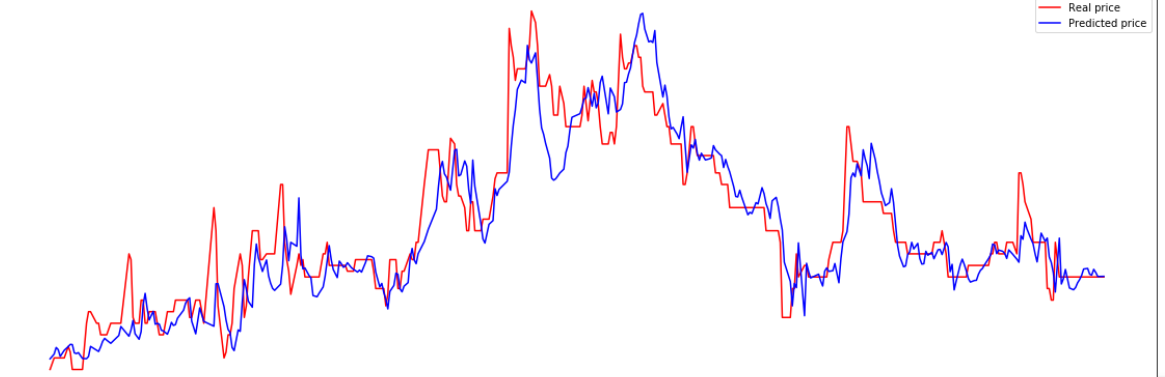

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, y_train, epochs = 500, batch_size = 512);

Epoch 1/500
4/4 [==============================] - 8s 243ms/step - loss: 0.0466
Epoch 2/500
4/4 [==============================] - 1s 250ms/step - loss: 0.0163
Epoch 3/500
4/4 [==============================] - 1s 262ms/step - loss: 0.0163
Epoch 4/500
4/4 [==============================] - 1s 258ms/step - loss: 0.0129
Epoch 5/500
4/4 [==============================] - 1s 284ms/step - loss: 0.0119
Epoch 6/500
4/4 [==============================] - 1s 269ms/step - loss: 0.0105
Epoch 7/500
4/4 [==============================] - 1s 254ms/step - loss: 0.0099
Epoch 8/500
4/4 [==============================] - 1s 246ms/step - loss: 0.0092
Epoch 9/500
4/4 [==============================] - 1s 236ms/step - loss: 0.0083
Epoch 10/500
4/4 [==============================] - 1s 310ms/step - loss: 0.0083
Epoch 11/500
4/4 [==============================] - 2s 385ms/step - loss: 0.0073
Epoch 12/500
4/4 [==============================] - 1s 300ms/step - loss: 0.0070
Epoch 13/500
4/4 [===================

4/4 [==============================] - 1s 254ms/step - loss: 0.0029
Epoch 103/500
4/4 [==============================] - 1s 217ms/step - loss: 0.0030
Epoch 104/500
4/4 [==============================] - 1s 297ms/step - loss: 0.0029
Epoch 105/500
4/4 [==============================] - 1s 289ms/step - loss: 0.0031
Epoch 106/500
4/4 [==============================] - 1s 276ms/step - loss: 0.0029
Epoch 107/500
4/4 [==============================] - 1s 267ms/step - loss: 0.0030
Epoch 108/500
4/4 [==============================] - 1s 230ms/step - loss: 0.0029
Epoch 109/500
4/4 [==============================] - 1s 212ms/step - loss: 0.0028
Epoch 110/500
4/4 [==============================] - 1s 260ms/step - loss: 0.0029
Epoch 111/500
4/4 [==============================] - 1s 238ms/step - loss: 0.0028
Epoch 112/500
4/4 [==============================] - 1s 239ms/step - loss: 0.0026
Epoch 113/500
4/4 [==============================] - 1s 229ms/step - loss: 0.0028
Epoch 114/500
4/4 [===========

## Prediction

In [ ]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_records + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [ ]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)
len(predict)

In [ ]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

The MSE result has been minimized enough to proceed with the prediction.

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted price')
# plt.xticks(np.arange(0,df[1800:].shape[0],25), rotation=45)
plt.title('Green Chillies Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

The predicted prices are close to the real prices. They could be over fitted as the prediction line fits the real line almost perfectly.

## 30-day prediction

In [ ]:
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(30):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

len(prediction_full)

In [ ]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

len(prediction_full_new)

In [ ]:
df_date = df[['Date']]

for h in range(30):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)
len(df_date)

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

The first days predictions show a sudden drop in prices that may be too deep and fast, followed by a also fast and quick increase. The model seems to be too responsive.

## GRU (Gated Recurrent Units)

In [ ]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

In [ ]:
modelGRU.compile(optimizer='adam', loss='mse')
modelGRU.fit(X_train, y_train, epochs=1000, batch_size=64)

In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

The MSE result has been minimized enough to proceed with the prediction.

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df[num_records:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

## 30-day prediction

In [ ]:
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(30):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_records]
    test_ = df_[num_records:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [ ]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(30):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[num_records:], df_volume[num_records:], color = 'red', label = 'Real Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
# plt.xticks(np.arange(0,df_date[1800:].shape[0],25), rotation=45)
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

The first days predictions show a sudden drop in prices that may be too deep and fast, followed by a also fast and quick increase. The model seems to be too responsive, as did the previous one.